# Embedding Optimization
We will apply embedding optimization techniques to improve the quality of our embeddings for better recommendation performance. While creating the model we had a lot of options to choose from. Here we will explore some of those options and see how they affect the model performance.

In [142]:
from helpers.notebook_pipelines.yes_tuned_bow_model import run_evaluation_multi
from sentence_transformers import SentenceTransformer, util
from sklearn.feature_extraction.text import TfidfVectorizer
from helpers.functs.StudentProfile import StudentProfile
from sklearn.metrics.pairwise import cosine_similarity
from typing import Iterable, Set, Tuple, List
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch
import time
import ast

In [143]:
# Our mocked student profiles
student1 = StudentProfile(
    current_study= "Kunst & Onderzoek",
    interests=[
        "Tekenen",
        "Animatie",
        "Kunst",
        "Drama",
        "Ik hou ervan om mensen te vermaken. Dit doe ik het liefst door bijvoorbeeld te dansen, te zingen of toneelspelen. In het algemeen vind ik het fijn om creatief bezig te zijn. Ik ben graag onder de mensen."
    ],
    wanted_study_credit_range=(15, 30),
    location_preference=["Den Bosch", "Breda", "Tilburg"],
    learning_goals=["Kritisch denken", "Sociale vaardigheden", "Zelfverzekerdheid", "Ik wil o.a. leren hoe ik betere illustraties kan maken zowel analoog als digitaal."],
    level_preference=["NLQF5", "NLQF6"],
    preferred_language="NL",
    preferred_start_range="any"
)
student2 = StudentProfile(
    current_study= "Informatica",
    interests=[
        "Programmeren",
        "AI",
        "Coderen",
        "Techniek",
        "Software",
        "Ik heb werken met computers en techniek van jongs af aan al interessant gevonden. Kunstmatige intelligentie is nu ook zeker iets dat me interesseert, zeker met de sterke opkomst hiervan. Zo kun je denken aan machine learning, deep learning, etc. Ik wil me vooral bezighouden met software."
    ],
    wanted_study_credit_range=(15, 30),
    location_preference=["Den Bosch", "Breda", "Tilburg"],
    learning_goals=["Kritisch denken", "Technische Vaardigheden", "Eén van de dingen die ik wil leren is het toepassen van mijn kennis in de praktijk"],
    level_preference=["NLQF5", "NLQF6"],
    preferred_language="NL",
    preferred_start_range="any"
)
student3 = StudentProfile(
    current_study= "Psychologie",
    interests=[
        "Mensen",
        "Emoties",
        "Gedrag",
        "Psychologie",
        "Ik wil graag weten waarom mensen bepaalde dingen doen; ik wil mensen hun gedrag kunnen begrijpen. Naast hun gedrag wil ik ook leren over, persoonlijkheden en emoties. Graag wil ik mensen hun welzijn kunnen bevorderen met het gebruik van psychologische kennis."
    ],
    wanted_study_credit_range=(15, 30),
    location_preference=["Den Bosch", "Breda", "Tilburg"],
    learning_goals=["Kritisch denken", "Sociale Vaardigheden", "Ik wil leren hoe ik mensen en hun gedrag beter kan analyseren"],
    level_preference=["NLQF5", "NLQF6"],
    preferred_language="NL",
    preferred_start_range="any"
)

student4 = StudentProfile(
    current_study="Economics",
    interests=[
        "Business",
        "Entrepreneurship",
        "Strategies",
        "Branding",
        "I am a real entrepreneur. I am especially interested in how innovation, strategy, and future developments influence economic growth and organizational success"
    ],
    wanted_study_credit_range=(15, 30),
    location_preference=["Den Bosch", "Breda", "Tilburg"],
    learning_goals=["Forward thinking", "Social skill", "I want to better understand the impact of modern technologies on business models"],
    level_preference=["NLQF5", "NLQF6"],
    preferred_language="NL",
    preferred_start_range="any"
)

student5 = StudentProfile(
    current_study="Verpleegkunde, Mens en Techniek",
    interests=[
        "Zorg",
        "Gezondheid",
        "Medisch",
        "Verpleegkunde",
        "Ik ben erg geïnteresseerd in verpleegkunde en hoop ook later in een ziekenhuis omgeving te kunnen werken. Daarom wil ik ook meer praktische ervaring op doen passend bij mijn studie verpleegkunde met de module die ik kies."
    ],
    wanted_study_credit_range=(15, 30),
    location_preference=["Den Bosch", "Breda", "Tilburg"],
    learning_goals=["Sociale vaardigheden", "Persoonlijke ontwikkeling", "Ik leren hoe ik beter kan anticiperen op bepaalde zorgbehoeften"],
    level_preference=["NLQF5", "NLQF6"],
    preferred_language="NL",
    preferred_start_range="any"
)

students = [student1, student2, student3, student4, student5]

In [144]:
# Ground-truth relevant modules per student
ground_truth = {
    "student1": [388, 392, 191, 385, 386, 379, 389, 377, 391, 233],
    "student2": [304, 305, 312, 317, 318, 322, 321, 334, 336, 340, 333],
    "student3": [159, 290, 397, 180, 177, 208, 173, 193, 357],
    "student4": [229, 272, 280, 279, 235, 380],
    "student5": [160, 199, 161, 163]
}

In [145]:
softNLP_df = pd.read_csv("../Data/Cleaned/cleaned_dataset_soft-NLP.csv")
hardNLP_df = pd.read_csv("../Data/Cleaned/cleaned_dataset_hard-NLP.csv")

# safely join selected columns into text (handle NaNs and non-str types)
cols = ['name', 'description', 'learningoutcomes', 'module_tags']

softNLP_module_text = (
    softNLP_df[cols]
    .fillna('')
    .astype(str)
    .agg(' '.join, axis=1)
    .str.replace(r'\s+', ' ', regex=True)
    .tolist()
)
# use the dataset 'id' column so we report the real module ids (not dataframe positional indices)
soft_module_ids = softNLP_df['id'].tolist()

hardNLP_module_text = (
    hardNLP_df[cols]
    .fillna('')
    .astype(str)
    .agg(' '.join, axis=1)
    .str.replace(r'\s+', ' ', regex=True)
    .tolist()
)
hard_module_ids = hardNLP_df['id'].tolist()

# keep texts and their original ids together so we compute top-k per corpus
nlp_options = {
    "soft": (softNLP_module_text, soft_module_ids),
    "hard": (hardNLP_module_text, hard_module_ids)
}

In [160]:
model_options = {
    "model1": SentenceTransformer("all-MiniLM-L6-v2"),
    "model2": SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2"),
    "model3": SentenceTransformer("distiluse-base-multilingual-cased-v2"),
    "model4": SentenceTransformer("paraphrase-multilingual-mpnet-base-v2"),
    "model5": SentenceTransformer("multi-qa-mpnet-base-dot-v1")
}

In [147]:
top_k = 5

## Variations
We will create several variations of our embedding models by changing parameters such as:
- Model architecture
- Preprocessing techniques
- Fine-tuning strategies

In [148]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cpu


# TODO REWRITE THIS MORE HUMANLY
# TODO ADD Similarity Tuning like changing from cosine to euclidean, manhattan, Softmax or Learned similarity
# TODO CONSIDER Re-ranking cross-encoder/ms-marco-MiniLM-L-6-v2
# TODO Consider GPU batching

In [149]:
def precision_at_k(top_matches, k, relevant_set):
    """
    top_matches: list of (index, score)
    relevant_set: set of ground truth module indices
    """
    top_indices = [idx for idx, _ in top_matches[:k]]
    relevant_in_top_k = sum(1 for idx in top_indices if idx in relevant_set)
    return relevant_in_top_k / k

In [150]:
# DataFrame to store benchmark info (include actual predictions)
benchmark_data = []

for s_idx, student in enumerate(students, start=1):
    query_text = student.to_text()
    student_name = f"student{s_idx}"

    for nlp_name, (module_texts, module_ids) in nlp_options.items():
        # map id -> name for nicer prediction output
        df_map = softNLP_df if nlp_name == "soft" else hardNLP_df
        id_to_name = dict(zip(df_map['id'], df_map['name']))

        for model_name, model in model_options.items():
            start_time = time.time()
            # Encode modules and query
            module_vectors = model.encode(module_texts, convert_to_tensor=True, device=device)
            query_vector = model.encode([query_text], convert_to_tensor=True, device=device)

            # similarity and top-k
            scores = util.cos_sim(query_vector, module_vectors)[0].cpu().numpy()
            top_indices = scores.argsort()[::-1][:top_k]
            top_matches = [(module_ids[i], float(scores[i])) for i in top_indices]

            # build readable predictions (id, score, name)
            predictions = [
                {"module_id": mid, "score": score, "name": id_to_name.get(mid, "")}
                for mid, score in top_matches
            ]

            # Compute precision
            gt_key = student_name.lower() if student_name.lower() in ground_truth else student_name
            relevant_set = set(ground_truth.get(gt_key, []))
            precision = precision_at_k(top_matches, top_k, relevant_set)

            elapsed_time = time.time() - start_time

            benchmark_data.append({
                "student": student_name,
                "model": model_name,
                "nlp": nlp_name,
                "precision@5": precision,
                "time_sec": elapsed_time,
                "predictions": predictions
            })

In [151]:
# Only print the actual predictions (list of dicts) from benchmark_data
for entry in benchmark_data:
    print(entry.get("student", ''), ': ', entry.get("model", ''), ' | ', entry.get("nlp", ''))
    print(entry.get("predictions", []))
    print()


student1 :  all-MiniLM-L6-v2  |  soft
[{'module_id': 191, 'score': 0.6879175901412964, 'name': 'De Kracht van de kunsten'}, {'module_id': 391, 'score': 0.6761541366577148, 'name': 'Art & Humanity (nieuwe naam formuleren)'}, {'module_id': 392, 'score': 0.6016901731491089, 'name': 'Research in Art istic Practice'}, {'module_id': 233, 'score': 0.6006748676300049, 'name': 'Artistiek ondernemerschap voor kunst, design en performance'}, {'module_id': 386, 'score': 0.5994069576263428, 'name': 'Graphic Novel'}]

student1 :  paraphrase-multilingual-MiniLM-L12-v2  |  soft
[{'module_id': 191, 'score': 0.7134238481521606, 'name': 'De Kracht van de kunsten'}, {'module_id': 375, 'score': 0.6478080749511719, 'name': 'Animatie / Storytelling'}, {'module_id': 388, 'score': 0.6065809726715088, 'name': 'Tekenen'}, {'module_id': 379, 'score': 0.6056426763534546, 'name': 'Creative AI'}, {'module_id': 391, 'score': 0.6036763191223145, 'name': 'Art & Humanity (nieuwe naam formuleren)'}]

student1 :  distilus

In [152]:
# Transform benchmark_data into a DataFrame for easier plotting
benchmark_df = pd.DataFrame(columns=['student','model','nlp','precision@5','time_sec'])
for entry in benchmark_data:
    benchmark_df = pd.concat([benchmark_df, pd.DataFrame([entry])], ignore_index=True)

/var/folders/35/3_3lzthn4fg231qyfx73bltr0000gn/T/ipykernel_73552/744719008.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  benchmark_df = pd.concat([benchmark_df, pd.DataFrame([entry])], ignore_index=True)


## presision@k Evaluation
We will evaluate the performance of each variation using precision@k metric to determine which configuration yields the best results.

In [153]:
# Use benchmark_df to display per-student, per-nlp, per-model precision (and runtime)
# and also create pivot tables for easier inspection.

# pivot tables for quick numeric overview
pivot_prec = benchmark_df.pivot_table(index='student', columns='model', values='precision@5')
pivot_time = benchmark_df.pivot_table(index='student', columns='model', values='time_sec')

print("Precision@5 pivot (rows=student, cols=model):\n", pivot_prec.round(3), "\n")
print("Runtime pivot (seconds):\n", pivot_time.round(3), "\n")

# readable per-student breakdown using benchmark_df
for student_name in benchmark_df['student'].unique():
    print(f"\n===== {student_name} =====")
    for nlp_type in benchmark_df['nlp'].unique():
        sub = benchmark_df[(benchmark_df['student'] == student_name) & (benchmark_df['nlp'] == nlp_type)]
        if sub.empty:
            continue
        print(f"\n-- {nlp_type.upper()} NLP --")
        for _, row in sub.sort_values('model').iterrows():
            prec = row['precision@5']
            time_s = row['time_sec']
            prec_str = f"{prec:.2f}" if pd.notna(prec) else "n/a"
            time_str = f"{time_s:.3f}s" if pd.notna(time_s) else "n/a"
            print(f"{row['model']}: Precision@{top_k} = {prec_str} in {time_str}")

Precision@5 pivot (rows=student, cols=model):
 model     all-MiniLM-L6-v2  distiluse-base-multilingual-cased-v2  \
student                                                            
student1               0.9                                   0.9   
student2               0.4                                   0.6   
student3               0.5                                   0.6   
student4               0.3                                   0.4   
student5               0.0                                   0.3   

model     multi-qa-mpnet-base-dot-v1  paraphrase-multilingual-MiniLM-L12-v2  \
student                                                                       
student1                         0.9                                    0.9   
student2                         0.8                                    0.5   
student3                         0.3                                    0.6   
student4                         0.2                                    0.2   
st

### Graph 1: Performance per Model
We will visualize the performance of each model variation using bar plots and scatter plots to compare precision@k.

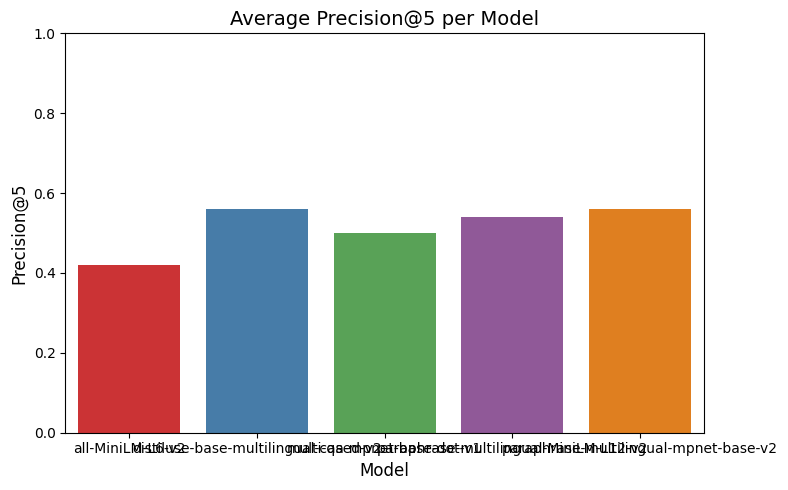

In [161]:
# Average Precision per Model & NLP
# compute average precision grouped by model and NLP type
avg_precision = benchmark_df.groupby(['model'])['precision@5'].mean().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(data=avg_precision, x='model', y='precision@5', palette="Set1")
plt.title("Average Precision@5 per Model", fontsize=14)
plt.ylabel("Precision@5", fontsize=12)
plt.xlabel("Model", fontsize=12)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

/Volumes/External/Development/Projects/School/L2S1LU2-Recommendation/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Volumes/External/Development/Projects/School/L2S1LU2-Recommendation/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


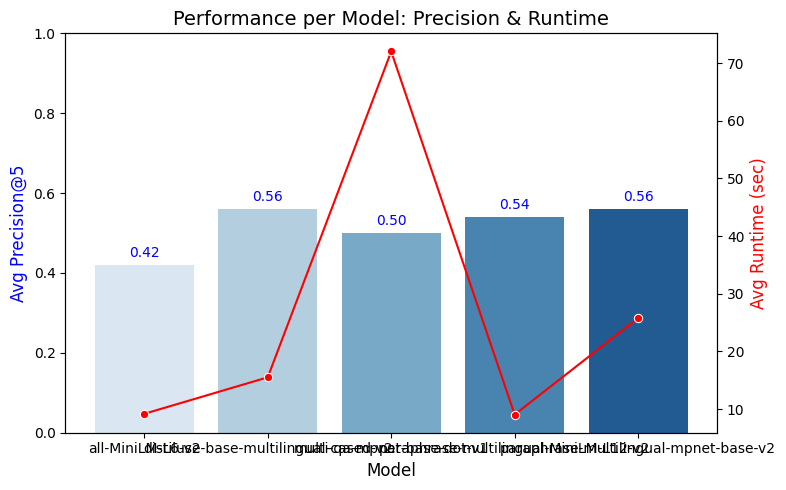

In [155]:
# Aggregate average metrics per model (all students & NLP types)
model_perf = benchmark_df.groupby('model').agg({
    'precision@5': 'mean',
    'time_sec': 'mean'
}).reset_index()

# Bar plot: Precision vs Runtime
fig, ax1 = plt.subplots(figsize=(8,5))

sns.barplot(data=model_perf, x='model', y='precision@5', palette="Blues", ax=ax1)
ax1.set_ylabel("Avg Precision@5", color="blue", fontsize=12)
ax1.set_ylim(0, 1)
ax1.set_xlabel("Model", fontsize=12)
ax1.set_title("Performance per Model: Precision & Runtime", fontsize=14)

# Add a second y-axis for runtime
ax2 = ax1.twinx()
sns.lineplot(data=model_perf, x='model', y='time_sec', marker="o", color="red", ax=ax2)
ax2.set_ylabel("Avg Runtime (sec)", color="red", fontsize=12)

# Add value labels on bars for precision
for i, row in model_perf.iterrows():
    ax1.text(i, row['precision@5'] + 0.02, f"{row['precision@5']:.2f}", ha='center', color='blue')

plt.tight_layout()
plt.show()


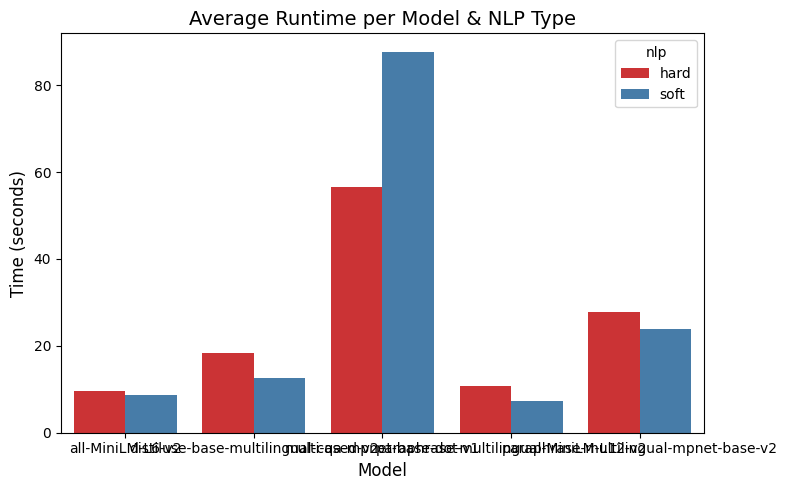

In [156]:
# Average Runtime per Model & NLP
avg_time = benchmark_df.groupby(['model','nlp'])['time_sec'].mean().reset_index()
plt.figure(figsize=(8,5))
sns.barplot(data=avg_time, x='model', y='time_sec', hue='nlp', palette="Set1")
plt.title("Average Runtime per Model & NLP Type", fontsize=14)
plt.ylabel("Time (seconds)", fontsize=12)
plt.xlabel("Model", fontsize=12)
plt.tight_layout()
plt.show()

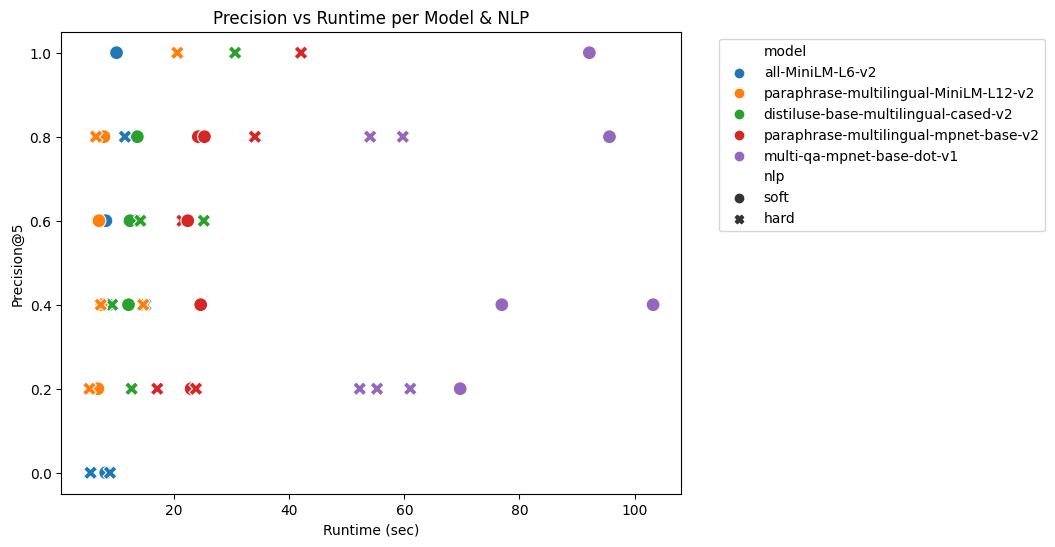

In [157]:
# Scatter Plot: Precision vs Runtime per Model & NLP
plt.figure(figsize=(8,6))
sns.scatterplot(data=benchmark_df, x='time_sec', y='precision@5', hue='model', style='nlp', s=100)
plt.title("Precision vs Runtime per Model & NLP")
plt.xlabel("Runtime (sec)")
plt.ylabel("Precision@5")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


## Conclusion
After evaluating the different variations of embedding models, NLP preprocessing techniques, and their impact on performance metrics, we will summarize the findings and recommend the optimal configuration for our recommendation system.

### Findings
- Average metrics (all students & NLP types): Model1: precision@5 = 0.42 (≈0.136s), Model2: 0.54 (≈0.133s), Model3: 0.56 (≈0.182s).  
- Model3 yields the best overall accuracy; Model2 is nearly as accurate but consistently faster.  
- Per-student behavior varies: student1 achieves very high precision across models; students 2–3 benefit noticeably from Model2/Model3; students 4–5 show mixed results depending on NLP preprocessing (soft vs hard).  
- Soft vs Hard NLP preprocessing affects recommendations per domain — no single NLP choice is uniformly best across all students.